# Marc 3 results 

read and analyse the optimization results. 

In [1]:
import os, sys, glob, pdb, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import softmax_params, make_soft_B

root = os.getcwd()
data_path = os.path.join(root, 'data_trustgame_depression')
opt_res_path = os.path.join(root, 'opt_results')
fig_path = os.path.join(root, 'plots')

mother = os.path.dirname(root)
os.chdir(mother)
from gms import *

In [2]:
os.chdir(data_path)
df = pd.read_csv('final_data.csv')
subjects = list(df['Participant Private ID'].unique())

In [3]:
os.chdir(opt_res_path)
pkl_res = glob.glob("*.pkl")

In [4]:
# filter results to find all results that belong to one subject
sbj_results = {sbj: [] for sbj in subjects}
for sbj in subjects: 
    for res in pkl_res: 
        if f'_{sbj}_' in res: 
            sbj_results[sbj].append(res)

In [5]:
best_pars = {sbj: [] for sbj in subjects}
min_cost_sbj = {}

for sbj in subjects:
    sbj_files = sbj_results[sbj]
    
    min_cost = 5
    for f in sbj_files: 
        file = open(f, 'rb')
        run = pickle.load(file)
        cost = run['fun']
        if cost < min_cost:
            min_cost = cost
            best_pars[sbj] = run['x']
            
    min_cost_sbj[sbj] = min_cost

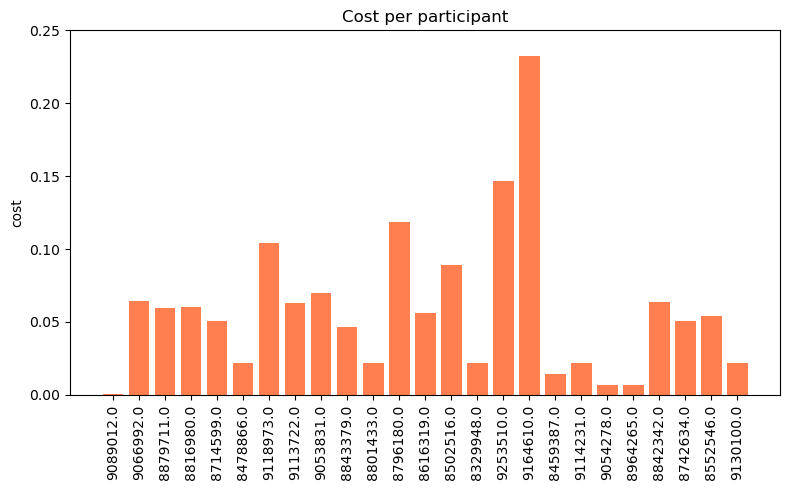

In [37]:
plt.figure(figsize=(8,5))
plt.title('Cost per participant')
string_keys = [str(key) for key in min_cost_sbj.keys()]
plt.bar(string_keys, min_cost_sbj.values(), color='coral')
plt.ylim(0.0, 0.25)
_=plt.xticks(rotation=90)
_=plt.ylabel('cost')
plt.tight_layout()
os.chdir(fig_path)
plt.savefig('optimizer_costs.svg')

In [7]:
soft_pars = {}
for item in best_pars.items():
    sbj_id = item[0]
    soft_sbj = softmax_params(*list(item[1]))
    soft_pars[sbj_id] = soft_sbj
    
df_p = pd.DataFrame.from_dict(soft_pars).T

In [8]:
# catch BDI score and condition for each participant. 
bdi = dict()
conditions = dict()
for sbj in subjects:
    df_sbj = df[df['Participant Private ID'] == sbj]
    sbj_bdi = df_sbj['BDI'].mean()
    condition = df_sbj['Spreadsheet'].unique()[0]
    bdi[sbj] = sbj_bdi
    conditions[sbj] = condition

# determine BDI median split subjects
bdi_median = np.median(list(bdi.values()))
bdi_std = np.std(list(bdi.values()))

low_bdi = [sbj for sbj in subjects if bdi[sbj] < bdi_median]
high_bdi = [sbj for sbj in subjects if bdi[sbj] > bdi_median]

min_bdi = [sbj for sbj in subjects if bdi[sbj] < bdi_median - bdi_std]
max_bdi = [sbj for sbj in subjects if bdi[sbj] > bdi_median + bdi_std]

In [9]:
low_c = [val for key, val in dict(df_p['C']).items() if key in low_bdi]
high_c = [val for key, val in dict(df_p['C']).items() if key in high_bdi]
all_c = [val for key, val in dict(df_p['C']).items()]

In [10]:
# make a function to call the plots

def plot_c_violin(data, title=None, filename=None, A=False): 
    """
    data should be a list of list
    like low_c above. 
    """

    # Extract the 1st, 2nd, and 3rd elements from each sublist
    p_r0 = [x[0] for x in data]
    p_r1 = [x[1] for x in data]
    p_r2 = [x[2] for x in data]

    # Create a DataFrame to hold the data for plotting
    data = pd.DataFrame({
        'p_r0': p_r0,
        'p_r1': p_r1,
        'p_r2': p_r2
    })

    # violin plots
    plt.figure(figsize=(10, 4))
    if title==None: 
        plt.suptitle(r'$C$: optimized prior on outcomes')
    else:
        plt.suptitle(title)

    # win outcome
    plt.subplot(1, 3, 1)
    ax = sns.violinplot(data=p_r0, color='forestgreen')
    for patch in ax.collections:
        patch.set_alpha(0.5)
    if A==True: 
        plt.title(r'$p(return)$ - coop')
    else: 
        plt.title('win')
    plt.ylim(0.0, 1.0)
    plt.ylabel(r'$p$')

    # loss outocme
    plt.subplot(1, 3, 2)
    sns.violinplot(data=p_r1, color='coral', alpha=0.2)
    if A==True: 
        plt.title(r'$p(return)$ - hostile')
    else: 
        plt.title('loss')
    plt.ylim(0.0, 1.)

    # keep outcome
    plt.subplot(1, 3, 3)
    sns.violinplot(data=p_r2)
    
    if A==True: 
        plt.title(r'$p(return)$ - random')
    else: 
        plt.title('keep budget')
    plt.ylim(0., 1.)
    
    if filename!=None:
        plt.savefig(filename)

    plt.tight_layout()
    plt.show()

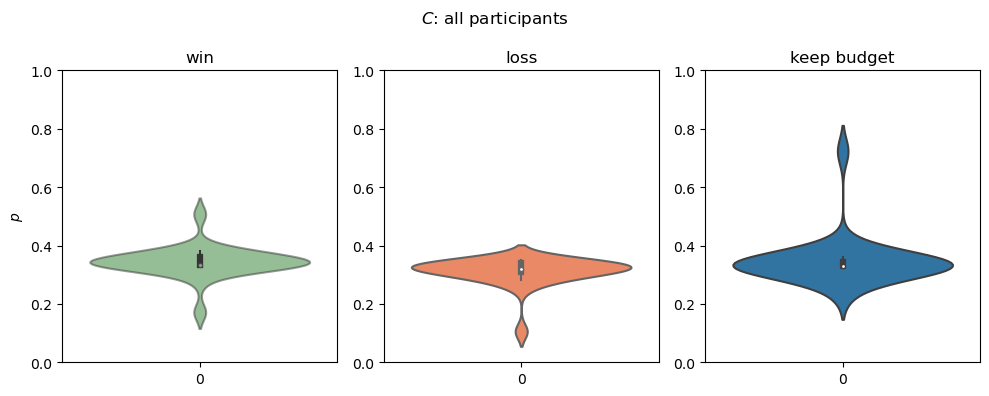

In [11]:
os.chdir(fig_path)
plot_c_violin(all_c, title=str(r'$C$: all participants'), filename='c_violin_all_participants.svg')

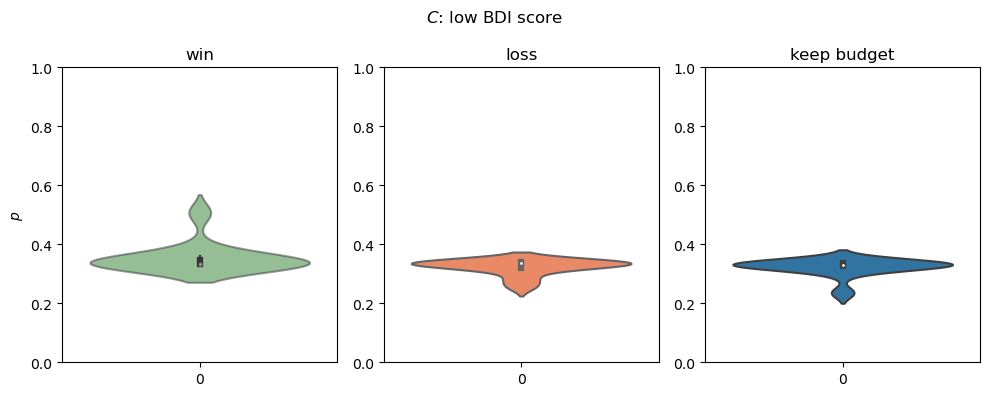

In [12]:
plot_c_violin(low_c, title=str(r'$C$: low BDI score'), filename='c_violin_low_score.svg')

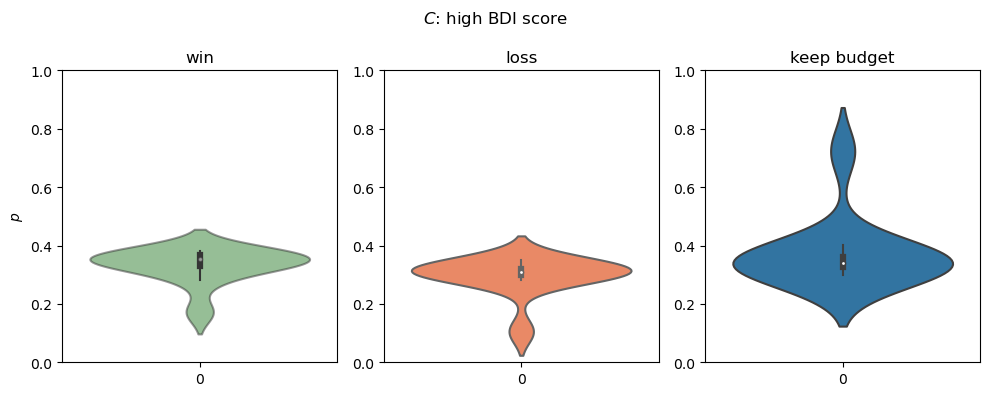

In [13]:
plot_c_violin(high_c, title=str(r'$C$: high BDI score'), filename='c_violin_high_score.svg')

In [14]:
# bar plot with the averages for each outcome. 
# Extract the 1st, 2nd, and 3rd elements from each sublist

def make_plottable(input_data): 
    p_r0 = [x[0] for x in input_data]
    p_r1 = [x[1] for x in input_data]
    p_r2 = [x[2] for x in input_data]

    # Create a DataFrame to hold the data for plotting
    data = pd.DataFrame({
        'p_r0': p_r0,
        'p_r1': p_r1,
        'p_r2': p_r2
    })
    
    return data

data_low = make_plottable(low_c)
data_high = make_plottable(high_c)

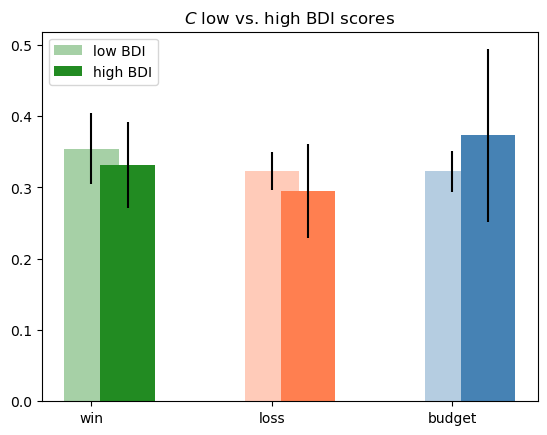

In [15]:
plt.bar(range(1,4), data_low.mean(), width=0.3, color=['forestgreen', 'coral', 'steelblue'],alpha=0.4, yerr=data_low.std(), label='low BDI')
plt.bar([l + 0.2 for l in list(range(1,4))], data_high.mean(), width=0.3, color=['forestgreen', 'coral', 'steelblue'], yerr=data_high.std(), label='high BDI')
plt.legend(loc='upper left')
_=plt.xticks(range(1,4), labels=['win', 'loss', 'budget'])
plt.title(r'$C$ low vs. high BDI scores')
os.chdir(fig_path)
plt.savefig('c_low_high_bar.svg')

In [16]:
# c for different conditions. pn, np, rand. 
# get list of subject names for all conditions. 
np_sbj   = [sbj for sbj, val in conditions.items() if val=='Negative-to-positive'] 
pn_sbj   = [sbj for sbj, val in conditions.items() if val=='Positive-to-negative']
rand_sbj = [sbj for sbj, val in conditions.items() if val=='Ambigious']

# catch c data per condition.
np_c = [val for key, val in dict(df_p['C']).items() if key in np_sbj]
pn_c = [val for key, val in dict(df_p['C']).items() if key in pn_sbj]
rand_c = [val for key, val in dict(df_p['C']).items() if key in rand_sbj]

data_np = make_plottable(np_c)
data_pn = make_plottable(pn_c)
data_rand  = make_plottable(rand_c)

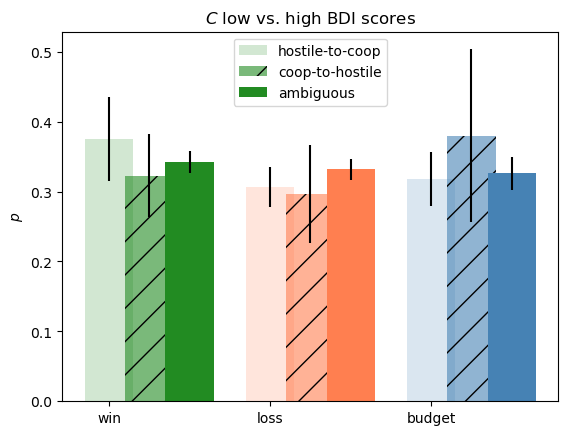

In [17]:
cols = ['forestgreen', 'coral', 'steelblue']
plt.bar(range(1,4), data_np.mean(), width=0.3, color=cols,alpha=0.2, yerr=data_np.std(), label='hostile-to-coop')
plt.bar([l + 0.25 for l in list(range(1,4))], data_pn.mean(), alpha=0.6, width=0.3, color=cols, hatch='/', yerr=data_pn.std(), label='coop-to-hostile')
plt.bar([l + 0.5 for l in list(range(1,4))], data_rand.mean(), width=0.3, color=cols, yerr=data_rand.std(), label='ambiguous')

plt.legend(loc='upper center')
_=plt.xticks(range(1,4), labels=['win', 'loss', 'budget'])
plt.title(r'$C$ low vs. high BDI scores')
plt.ylabel(r'$p$')
os.chdir(fig_path)
plt.savefig('c_conditions_bar.svg')

In [18]:
# D plots. 
low_d = [val for key, val in dict(df_p['D']).items() if key in low_bdi]
high_d = [val for key, val in dict(df_p['D']).items() if key in high_bdi]
all_d = [val for key, val in dict(df_p['D']).items()]

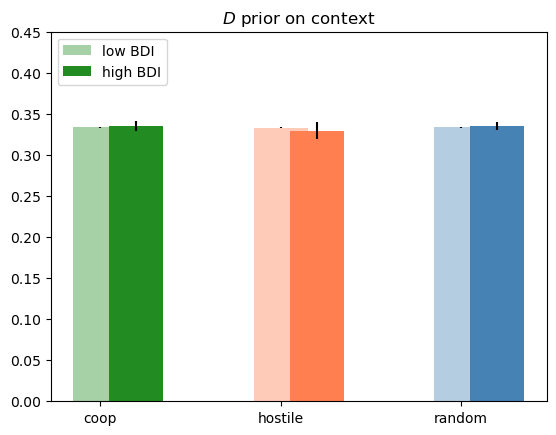

In [19]:
data_low = make_plottable(low_d)
data_high = make_plottable(high_d)

cols = ['forestgreen', 'coral', 'steelblue']

plt.bar(range(1,4), data_low.mean(), width=0.3, color=cols,alpha=0.4, yerr=data_low.std(), label='low BDI')
plt.bar([l + 0.2 for l in list(range(1,4))], data_high.mean(), width=0.3, color=cols, yerr=data_high.std(), label='high BDI')
plt.legend(loc='upper left')
plt.ylim(0, 0.45)
_=plt.xticks(range(1,4), labels=['coop', 'hostile', 'random'])
plt.title(r'$D$ prior on context')
os.chdir(fig_path)
plt.savefig('D_per_conditions.svg')

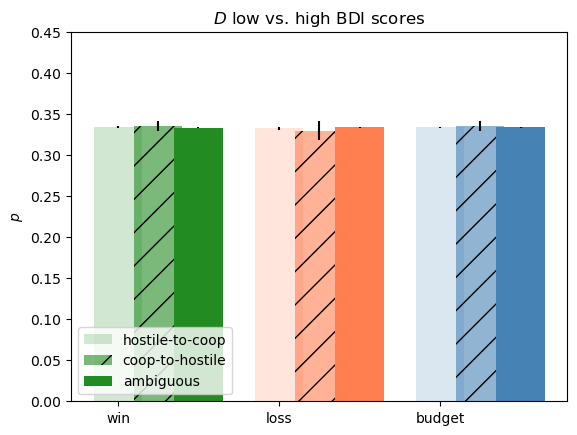

In [20]:
# catch c data per condition.
np_d = [val for key, val in dict(df_p['D']).items() if key in np_sbj]
pn_d = [val for key, val in dict(df_p['D']).items() if key in pn_sbj]
rand_d = [val for key, val in dict(df_p['D']).items() if key in rand_sbj]

data_np = make_plottable(np_d)
data_pn = make_plottable(pn_d)
data_rand  = make_plottable(rand_d)

plt.bar(range(1,4), data_np.mean(), width=0.3, color=cols,alpha=0.2, yerr=data_np.std(), label='hostile-to-coop')
plt.bar([l + 0.25 for l in list(range(1,4))], data_pn.mean(), alpha=0.6, width=0.3, color=cols, hatch='/', yerr=data_pn.std(), label='coop-to-hostile')
plt.bar([l + 0.5 for l in list(range(1,4))], data_rand.mean(), width=0.3, color=cols, yerr=data_rand.std(), label='ambiguous')

plt.legend(loc='lower left')
_=plt.xticks(range(1,4), labels=['win', 'loss', 'budget'])
plt.title(r'$D$ low vs. high BDI scores')
plt.ylabel(r'$p$')
plt.ylim(0, 0.45)
os.chdir(fig_path)
plt.savefig('D_per_conditions_bar.svg')

In [21]:
# plot p_share_friendly, p_share_hostile and p_share_random... as violin. 
low_a = [val for key, val in dict(df_p['A']).items() if key in low_bdi]
high_a = [val for key, val in dict(df_p['A']).items() if key in high_bdi]
all_a = [val for key, val in dict(df_p['A']).items()]

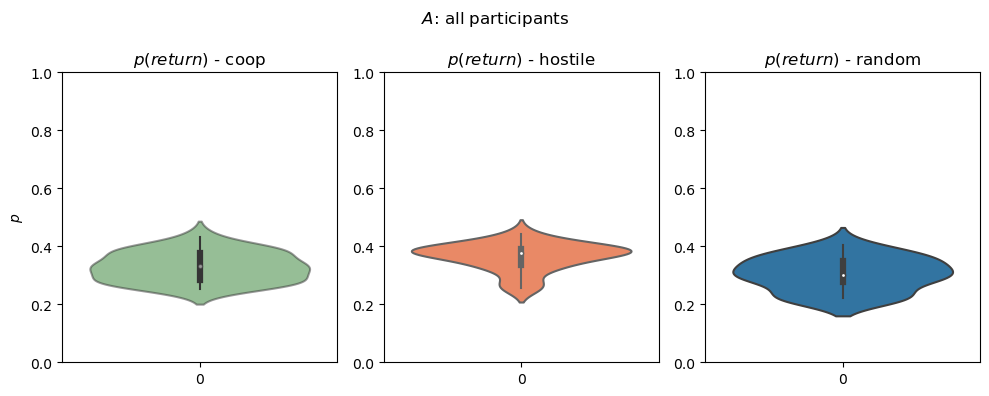

In [22]:
# something wrong here about the way we softmaxed I think. Put in appendix for now. 
plot_c_violin(all_a, title=str(r'$A$: all participants'), filename='A_violin_all_participants.svg', A=True)

In [23]:
# B: also here I think there might be problems with the way we softmaxed. 
soft_B_sbj = dict()

for sbj in subjects: 
    params = list(dict(df_p['B'])[sbj])
    soft_B = make_soft_B(*params)
    soft_B_sbj[sbj] = soft_B
    

In [24]:
test = 9089012.0
# friendly to friendly, hostile, random
soft_B_sbj[test][:, 1:2, :].flatten()

array([0.38365173, 0.38365174, 0.23269654])

In [25]:
sbj_friendly, sbj_hostile, sbj_random = {},{},{}

for sbj in subjects:
    friendly = soft_B_sbj[sbj][:, :1, :].flatten()
    hostile  = soft_B_sbj[sbj][:, 1:2, :].flatten()
    random   = soft_B_sbj[sbj][:, 2:3, :].flatten()
    
    sbj_friendly[sbj] = friendly
    sbj_hostile[sbj]  = hostile
    sbj_random[sbj]   = random
  

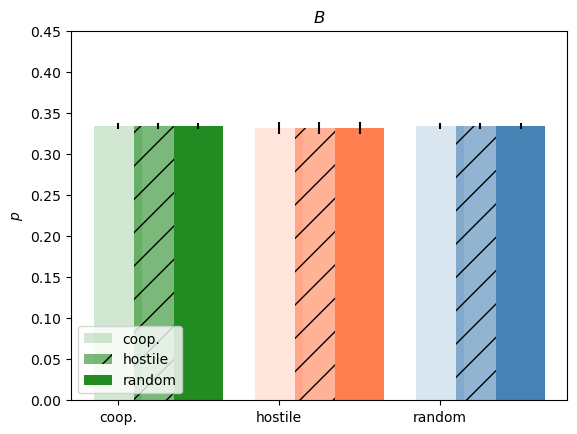

In [26]:
# catch B data per condition.
b_friendly = [val for key, val in dict(df_p['D']).items() if key in sbj_friendly]
b_hostile = [val for key, val in dict(df_p['D']).items() if key in sbj_hostile]
b_random = [val for key, val in dict(df_p['D']).items() if key in sbj_random]

data_b_friendly = make_plottable(b_friendly)
data_b_hostile = make_plottable(b_hostile)
data_b_random  = make_plottable(b_random)

plt.bar(range(1,4), data_b_friendly.mean(), width=0.3, color=cols,alpha=0.2, 
        yerr=data_b_friendly.std(), label='coop.')


plt.bar([l + 0.25 for l in list(range(1,4))], data_b_hostile.mean(), alpha=0.6, width=0.3, color=cols, hatch='/', 
        yerr=data_b_hostile.std(), label='hostile')


plt.bar([l + 0.5 for l in list(range(1,4))], data_b_random.mean(), width=0.3, color=cols, 
        yerr=data_b_random.std(), label='random')

plt.legend(loc='lower left')
_=plt.xticks(range(1,4), labels=['coop.', 'hostile', 'random'])
plt.title(r'$B$')
plt.ylabel(r'$p$')
plt.ylim(0, 0.45)
os.chdir(fig_path)
plt.savefig('B_all_together.svg')

In [27]:
# last thing: find the average parameters (ABCD) for highly depressed vs. lowly depressed and simulate agent with them. 
sorted_bdi = sorted(bdi.items(), key=lambda item: item[1])

min_bdi = sorted_bdi[:3]
max_bdi = sorted_bdi[-3:]

min_bdi_sbj = [sbj for sbj,score in min_bdi]
max_bdi_sbj = [sbj for sbj,score in max_bdi]

In [28]:
dict(df_p.loc[min_bdi_sbj]['C'])

{9118973.0: [0.5072846785073523, 0.2570657753105981, 0.23564954618204972],
 8842342.0: [0.343144254425578, 0.3146100405216032, 0.34224570505281876],
 9089012.0: [0.3328771055634062, 0.32108466403915653, 0.3460382303974372]}

In [29]:
dict(df_p.loc[max_bdi_sbj]['C'])

{9113722.0: [0.2822392171766389, 0.31623152146854383, 0.40152926135481715],
 9066992.0: [0.3533102353113868, 0.30800144950717573, 0.3386883151814375],
 8742634.0: [0.3339939305889025, 0.3095381507830881, 0.3564679186280094]}

In [31]:
np.mean([0.507, 0.34, 0.33])

0.39233333333333337

In [32]:
np.mean([0.28, 0.35, 0.33])

0.32